# Customer Churn Prediction

Model churn propensity for personal lines customers using synthetic policy servicing signals.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

## 1. Generate customer retention dataset

In [2]:
rng = np.random.default_rng(7)
n_samples = 2500

tenure_months = rng.integers(1, 120, n_samples)
claim_frequency = rng.poisson(0.5, n_samples)
premium = rng.normal(145, 30, n_samples).clip(50, 400)
interactions = rng.poisson(1.8, n_samples)
auto_bundle = rng.binomial(1, 0.4, n_samples)
home_bundle = rng.binomial(1, 0.35, n_samples)
payment_method = rng.choice(["ACH", "Credit Card", "Invoice"], n_samples, p=[0.5, 0.35, 0.15])
household_size = rng.integers(1, 6, n_samples)
agent_visits = rng.poisson(0.3, n_samples)
digital_engagement = rng.beta(2, 1.8, n_samples)

logit = (
    -2.1
    - 0.015 * tenure_months
    + 0.25 * claim_frequency
    + 0.008 * (premium - 150)
    - 0.35 * auto_bundle
    - 0.32 * home_bundle
    - 0.22 * digital_engagement
    + 0.18 * interactions
    + 0.12 * agent_visits
    + rng.normal(0, 0.25, n_samples)
)
churn_probability = 1 / (1 + np.exp(-logit))
churned = rng.binomial(1, churn_probability)

churn_df = pd.DataFrame(
    {
        "tenure_months": tenure_months,
        "claim_frequency": claim_frequency,
        "monthly_premium": premium,
        "service_interactions": interactions,
        "auto_bundle": auto_bundle,
        "home_bundle": home_bundle,
        "payment_method": payment_method,
        "household_size": household_size,
        "agent_visits": agent_visits,
        "digital_engagement_score": digital_engagement,
        "churned": churned,
    }
)

Path("data").mkdir(parents=True, exist_ok=True)
data_path = Path("data/customer_churn.csv")
churn_df.to_csv(data_path, index=False)
print(f"Dataset saved to {data_path.resolve()}")
churn_df.head()

Dataset saved to /Users/michaelmcdonogh/Documents/git/MachineLearningCalculateRiskPremium/CascadeProjects/windsurf-project/insurance-ml-demos/data/customer_churn.csv


,tenure_months,claim_frequency,monthly_premium,service_interactions,auto_bundle,home_bundle,payment_method,household_size,agent_visits,digital_engagement_score,churned
0,113,1,168.271721,0,0,1,ACH,1,0,0.592127,0
1,75,0,181.537474,5,0,0,Credit Card,4,0,0.651914,0
2,82,0,162.410759,1,1,1,Credit Card,4,0,0.339581,0
3,107,1,121.160028,3,0,1,ACH,4,0,0.819833,1
4,69,0,140.211017,2,1,0,Invoice,5,0,0.778584,0


## 2. Explore churn patterns

In [3]:
df = pd.read_csv("data/customer_churn.csv")
df.groupby("churned").mean(numeric_only=True)

,tenure_months,claim_frequency,monthly_premium,service_interactions,auto_bundle,home_bundle,household_size,agent_visits,digital_engagement_score
churned,,,,,,,,,
0,62.069758,0.490004,143.910876,1.828158,0.400255,0.366652,3.012335,0.305402,0.531344
1,46.469799,0.563758,147.385776,1.993289,0.328859,0.281879,3.020134,0.463087,0.502969


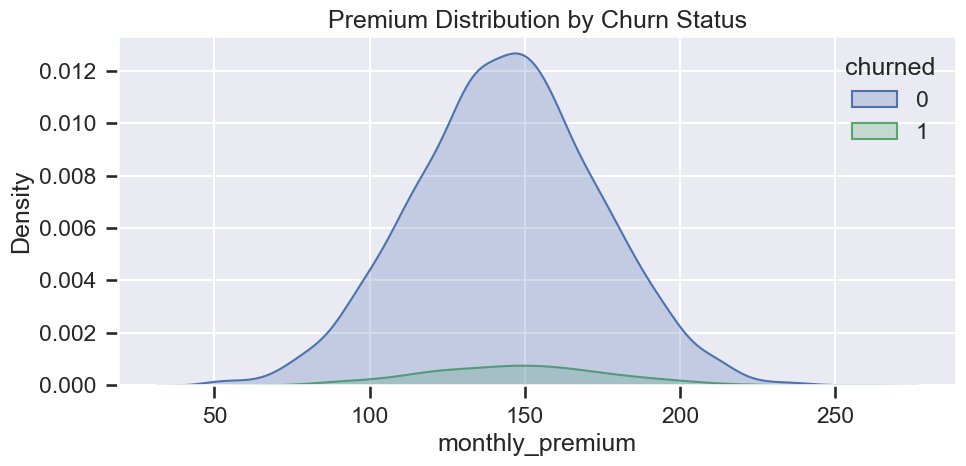

In [4]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x="monthly_premium", hue="churned", fill=True)
plt.title("Premium Distribution by Churn Status")
plt.tight_layout()
plt.show()

## 3. Train churn model

In [5]:
features = pd.get_dummies(df.drop(columns=["churned"]), drop_first=True)
target = df["churned"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=7, stratify=target
)

xgb_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=False)),
        (
            "model",
            XGBClassifier(
                random_state=7,
                n_estimators=300,
                learning_rate=0.05,
                max_depth=3,
                subsample=0.9,
                colsample_bytree=0.8,
                eval_metric="logloss"
            ),
        ),
    ]
)

xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       588
           1       1.00      0.03      0.05        37

    accuracy                           0.94       625
   macro avg       0.97      0.51      0.51       625
weighted avg       0.95      0.94      0.92       625



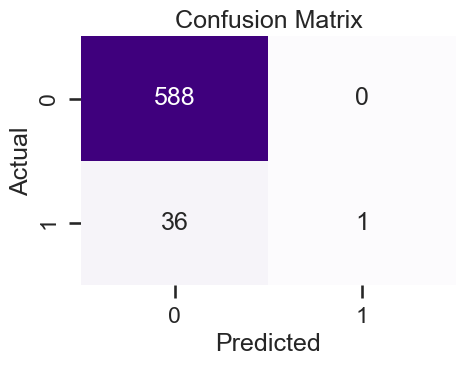

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

/var/folders/d2/4vnsb4hn5vq5bb7wds771vx80000gn/T/ipykernel_55969/2976656585.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='mako')


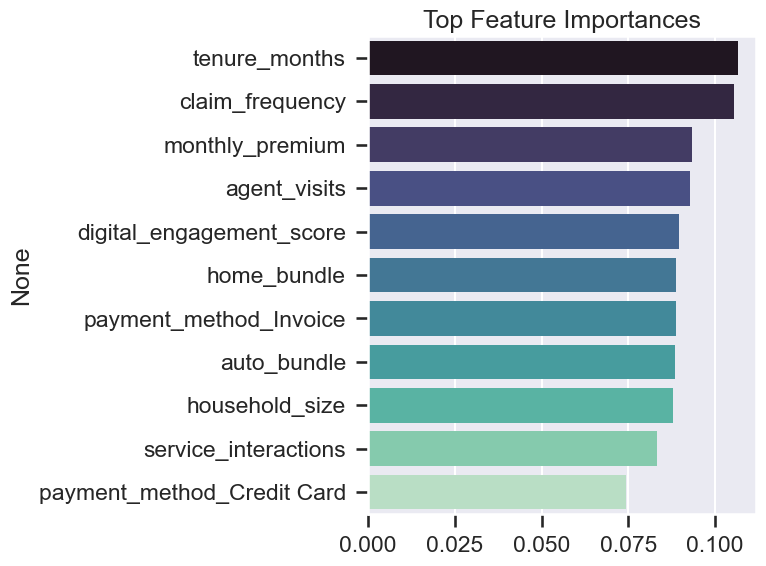

In [7]:
model = xgb_pipeline.named_steps["model"]
importance = pd.Series(model.feature_importances_, index=features.columns).sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=importance.values[:15], y=importance.index[:15], orient='h', palette='mako')
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()